In [1]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,Conv1D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from matplotlib.pyplot import imshow
from PIL import Image
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import glob
import matplotlib.image as mpimg
import random
%matplotlib inline

In [2]:
BASE_DIR = "../input/covid-pneumonia-normal-chest-xray-images/"
os.listdir(BASE_DIR)

['PNEUMONIA', 'NORMAL', 'COVID']

In [3]:
batch_size = 32
image_size = (256,256)
train_ds = image_dataset_from_directory(
    BASE_DIR,
    batch_size = batch_size,
    image_size = image_size,
    shuffle = True,
    seed = 42,
    validation_split = 0.2,
    subset = "training",
)
val_ds = image_dataset_from_directory(
    BASE_DIR,
    batch_size = batch_size,
    image_size = image_size,
    shuffle = True,
    seed = 42,
    validation_split = 0.2,
    subset = "validation",
)

Found 5228 files belonging to 3 classes.
Using 4183 files for training.
Found 5228 files belonging to 3 classes.
Using 1045 files for validation.


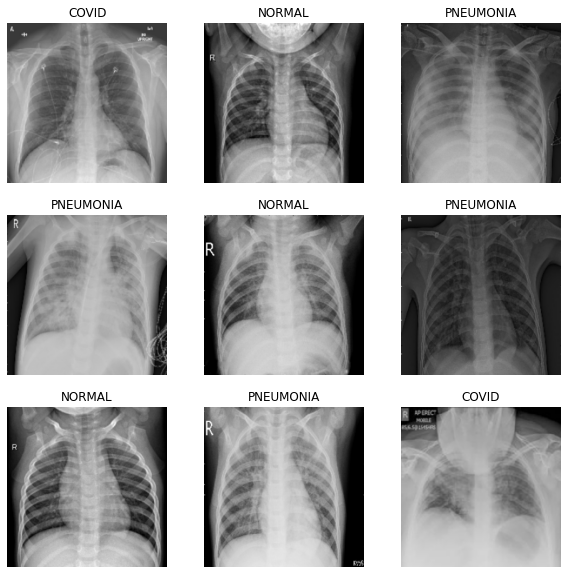

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
normalize_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [7]:
train_ds = train_ds.map(lambda x,y: (normalize_layer(x),y))
val_ds = val_ds.map(lambda x,y: (normalize_layer(x), y))

In [8]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    F1, F2, F3 = filters
    X_shortcut = X
    cache = []
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding="same", kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X,training=training)
    X = Activation('relu')(X)
    X = Conv2D(filters=F3, kernel_size = (1,1), strides = (1,1), kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training = training)
    X = Add()([X_shortcut,X])
    X = Activation("relu")(X)
    return X

In [9]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    X = Conv2D(filters=F2, kernel_size = (f,f), padding = "same", strides = (1,1), kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training = training)
    X = Activation('relu')(X)
    X = Conv2D(filters=F3, kernel_size = (1,1), strides = (1,1), padding="valid", kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X) 
    X_shortcut = Conv2D(filters=F3, kernel_size = (1,1), strides = (s,s), padding = "valid",kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [10]:
def ResNet50(input_shape = (256, 256,3)):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    # Stage 1
    X = Conv2D(64, kernel_size = (7,7), strides = (2,2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    ### START CODE HERE
    
    ## Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, s=2, filters = [128,128,512])
    X = identity_block(X,f=3,filters = [128,128,512]) 
    X = identity_block(X,f=3,filters = [128,128,512])
    X = identity_block(X,f=3,filters = [128,128,512])
    
    ## Stage 4 (≈6 lines)
    X = convolutional_block(X,f = 3, s=2,filters = [256,256,1024]) 
    X = identity_block(X,filters = [256,256,1024],f=3) 
    X = identity_block(X,filters = [256,256,1024],f=3)
    X = identity_block(X,filters = [256,256,1024],f=3)
    X = identity_block(X,filters = [256,256,1024],f=3)
    X = identity_block(X,filters = [256,256,1024],f=3)

    ## Stage 5 (≈3 lines)
    X = convolutional_block(X,f = 3, s=2,filters = [512,512,2048])
    X = identity_block(X,filters = [512,512,2048],f=3)
    X = identity_block(X,filters = [512,512,2048],f=3) 

    X = AveragePooling2D(pool_size=(2,2))(X) 
    X = Flatten()(X)
    X = Dense(units=256,activation=tf.keras.activations.relu)(X)
    X = Dense(units = 128, activation=tf.keras.activations.relu)(X)
    X = Dense(units=3, activation = "softmax")(X)
    model = Model(inputs = X_input, outputs = X)

    return model

In [11]:
model = ResNet50(input_shape = (256,256,3))

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
______________________________________________________________________________________________

In [13]:
model.compile(optimizer="adam",
             loss = "sparse_categorical_crossentropy",
             metrics = ["accuracy"])

In [14]:
epochs = 20
history = model.fit(train_ds,epochs=epochs)

Epoch 1/20
131/131 [==============================] - 63s 225ms/step - loss: 4.6799 - accuracy: 0.4592
Epoch 2/20
131/131 [==============================] - 29s 221ms/step - loss: 0.5288 - accuracy: 0.8362
Epoch 3/20
131/131 [==============================] - 29s 221ms/step - loss: 0.2502 - accuracy: 0.9136
Epoch 4/20
131/131 [==============================] - 29s 221ms/step - loss: 0.1874 - accuracy: 0.9351
Epoch 5/20
131/131 [==============================] - 29s 220ms/step - loss: 0.1631 - accuracy: 0.9398
Epoch 6/20
131/131 [==============================] - 29s 221ms/step - loss: 0.1543 - accuracy: 0.9476
Epoch 7/20
131/131 [==============================] - 29s 221ms/step - loss: 0.1371 - accuracy: 0.9487
Epoch 8/20
131/131 [==============================] - 29s 221ms/step - loss: 0.1095 - accuracy: 0.9594
Epoch 9/20
131/131 [==============================] - 29s 220ms/step - loss: 0.0941 - accuracy: 0.9720
Epoch 10/20
131/131 [==============================] - 29s 221ms/step - l

In [16]:
test_history = model.evaluate(val_ds)

33/33 [==============================] - 3s 84ms/step - loss: 0.1794 - accuracy: 0.9474


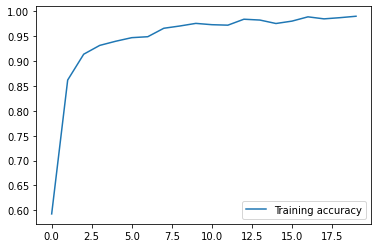

In [25]:
train_acc = []
train_acc += history.history["accuracy"]
plt.plot(train_acc,label="Training accuracy")
plt.legend()

In [26]:
batch_size = 32
image_size = (256,256)
experiment_ds = image_dataset_from_directory(
    BASE_DIR,
    batch_size = batch_size,
    image_size = image_size,
    shuffle = True,
    seed = 42,
    validation_split = 0.2,
    subset = "training",
)

Found 5228 files belonging to 3 classes.
Using 4183 files for training.


In [27]:
normalize_exp_ds = experiment_ds.map(lambda x,y : (normalize_layer(x),y))

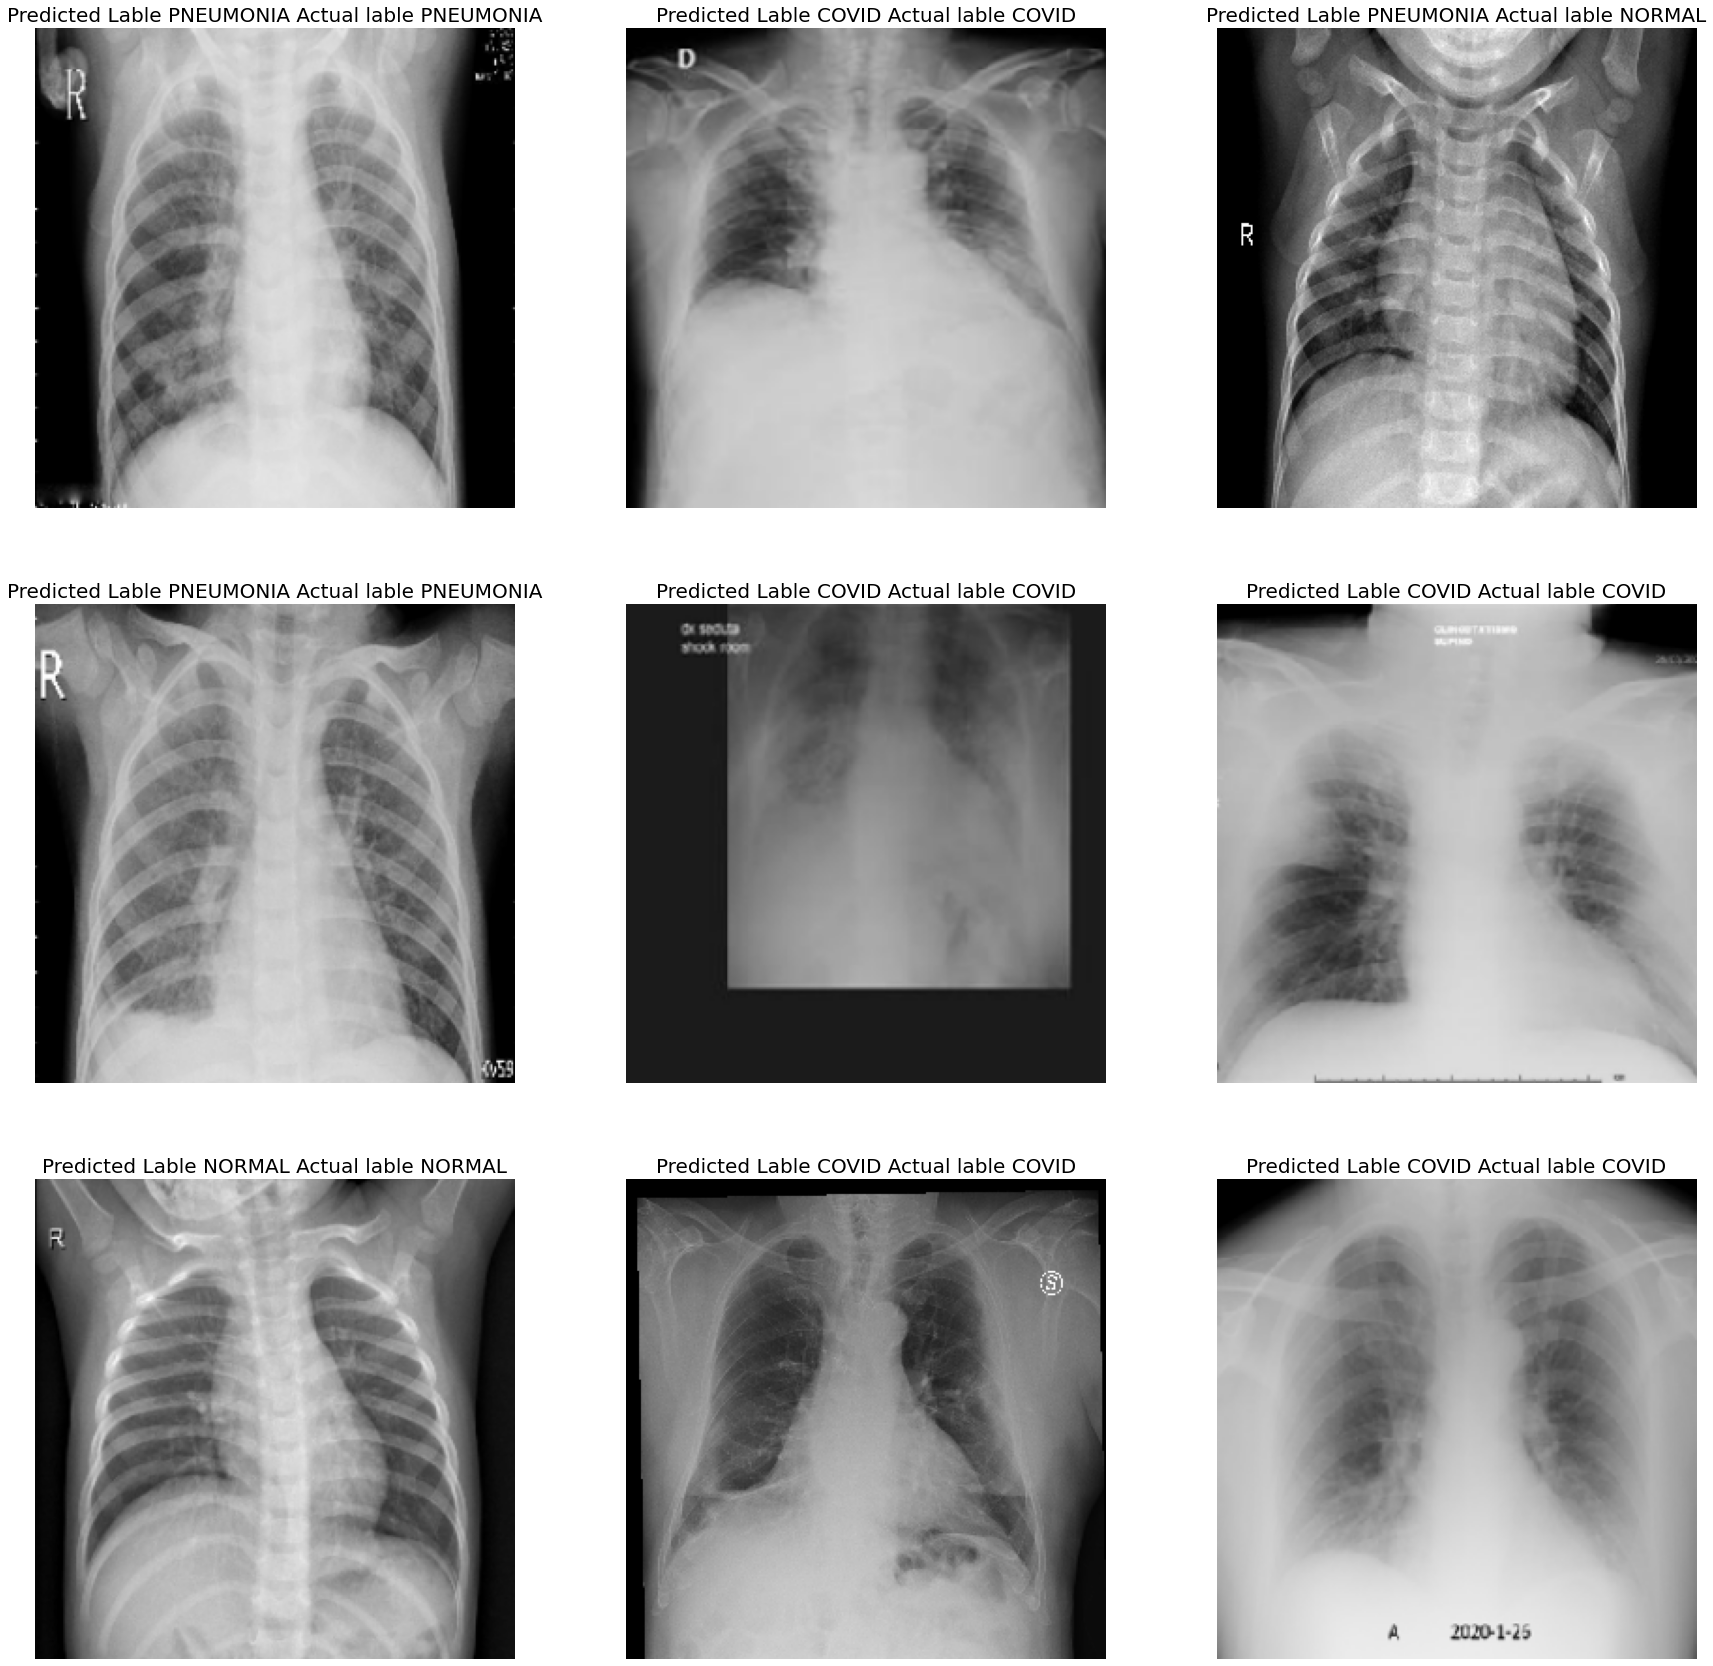

In [29]:
plt.figure(figsize=(30, 30))
for images, labels in experiment_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Predicted Lable "+ experiment_ds.class_names[np.argmax(model.predict((images[i].numpy().reshape((1,256,256,3))) / 255.))] +" Actual lable "+  experiment_ds.class_names[labels[i]],fontsize = 20)
        plt.axis("off")